# Partie 2
## Adapter un modèle pré-entrainé : fine-tuning, Dataset, régularisation

Lien vers le Google Colab: https://colab.research.google.com/drive/1QRsfMTxcH7IOhkNealykaC0EaBajHAuW?usp=sharing

Dans cette seconde partie, nous allons : 
 * Adapter l'architecture d'AlexNet pour un problème de segmentation sémantique d'images satellites,
 * Créer un torch.utils.data.Dataset adapté à notre application,
 * Fine-tuner le modèle,
 * Régulariser le modèle.
 
On utilisera un extrait de l'image RGB à haute résolution spatiale de Houston  [1].

Cet extrait peut être téléchargé ici : https://nextcloud.isae.fr/index.php/s/WmjQPyH3g2EK33x

[1]  Saurabh Prasad, Bertrand Le Saux, Naoto Yokoya, Ronny Hansch, December 18, 2020, "2018 IEEE GRSS Data Fusion Challenge – Fusion of Multispectral LiDAR and Hyperspectral Data", IEEE Dataport, doi: https://dx.doi.org/10.21227/jnh9-nz89. 

### Chargement des données

In [1]:
import rasterio
from rasterio.windows import Window
from rasterio.warp import reproject, Resampling
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
import torch
import torch.nn as nn
import torch.nn.functional as F

On utilise la bibliothèque rasterio pour caler la vérité terrain sur l'image RGB.

In [2]:
with rasterio.open('../data/UH_NAD83_272056_3289689.tif') as img:
    window = Window(0, 0, 1000, 1000)
    data = img.read(window=window)
    
with rasterio.open('../data/2018_IEEE_GRSS_DFC_GT_TR.tif') as gt_:
    gt = np.zeros(img.shape, dtype=np.uint8)
    reproject(
        source=gt_.read(1),
        destination=gt,
        src_transform=gt_.transform,
        src_crs=gt_.crs,
        dst_transform=img.transform,
        dst_crs=img.crs,
        resampling=Resampling.nearest)
    
img = data.transpose(1, 2, 0)
gt = gt[:1000, :1000]
for i, class_id in enumerate(np.unique(gt)):
    gt[class_id == gt] = i

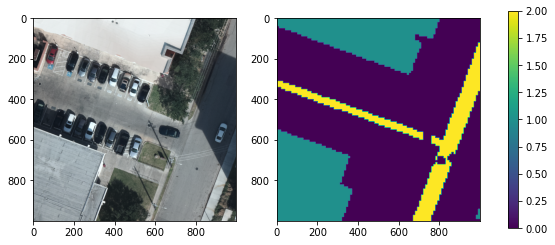

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(img)
ax1 = ax[1].imshow(gt)
fig.colorbar(ax1, ax=ax, shrink=0.4)
plt.show()

La vérité terrain est constituée de deux classes : les bâtiments et les routes.

### Création du Dataset PyTorch

Pour optimiser un modèle PyTorch par descente de gradient stochastique par batchs, on utilise deux objets :
 * un torch.utils.data.Dataset pour parcourir les exemples d'apprentissage,
 * un torch.utils.data.DataLoader pour faire des batchs d'exemples.
 
Si l'on avait des données structurées, on pourrait utiliser un torch.utils.data.TensorDataset comme suit : 

In [4]:
n_features = 8
n_examples = 50
n_classes = 4

data = torch.randn(n_examples, n_features)
labels = torch.randint(size=(n_examples, 1), low=1, high=n_classes+1)

dataset = torch.utils.data.TensorDataset(data, labels)
print(len(dataset))
data_loader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)
print(len(data_loader))

50
5


In [5]:
dataset.__getitem__(0)

(tensor([-2.4153,  1.0554,  0.4752,  0.4274, -0.3298,  1.0756, -1.2128, -0.8658]),
 tensor([4]))

Dans notre cas, les données ne sont pas organisées de cette façon. On souhaiterait en effet utiliser un modèle qui prenne en entrée des patchs de 51 x 51 pixels et qui prédise la classe du pixel central. Pour cela, on va construire notre propre torch.utils.data.Dataset (https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset).

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, gt, hyperparams):
        """
        Args:
            data: 3D hyperspectral image
            gt: 2D array of labels
            patch_size: int, size of the spatial neighbourhood
            ignored_labels: list of ints, labels to ignore

        """
        super(Dataset, self).__init__()
        self.data = data
        self.label = gt
        self.patch_size = hyperparams["patch_size"]
        self.ignored_labels = set(hyperparams["ignored_labels"])        
        self.height = data.shape[0]
        self.width = data.shape[1]

        mask = np.ones_like(gt)
        for l in self.ignored_labels:
            mask[gt == l] = 0

        x_pos, y_pos = np.nonzero(mask)
        p = self.patch_size // 2
        if p > 0:
            self.indices = np.array(
                [
                    (x, y)
                    for x, y in zip(x_pos, y_pos)
                    if x >= p and x < data.shape[0] - p and y >= p and y < data.shape[1] - p
                ]
            )
        else:
            self.indices = np.array(
                [
                    (x, y)
                    for x, y in zip(x_pos, y_pos)
                ]
            )
            
        self.labels = [self.label[x, y] for x, y in self.indices]

    def __len__(self):
        # A compléter 
        ... 

    def __getitem__(self, i):
        # A compléter
        x, y = ... 
        x1, y1 = x - self.patch_size // 2, y - self.patch_size // 2
        x2, y2 = x1 + self.patch_size, y1 + self.patch_size
        
        # A compléter
        data = ...
        label = ...

        # Copie de data et label dans des npy array
        data = np.asarray(np.copy(data).transpose((2, 0, 1)), dtype="float32")
        label = np.asarray(np.copy(label), dtype="int64")

        # Conversion des npy array en torch.tensor
        # A compléter
        data = ...
        label = ...

        return data, label

In [ ]:
hyperparams = {'ignored_labels': [0], 'patch_size': 51}
dataset = Dataset(img, gt, hyperparams)

# A compléter
train_dataset, val_dataset = ... # On souhaite couper le dataset en un set d'apprentissage et un set de validation

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=False)

On peut visualiser un exemple comme suit :

In [ ]:
for patch, label in train_loader:
    break
fig = plt.figure()
plt.imshow(patch[30,:,:,:].transpose(2,0)/256)
plt.show()

### Fine-tuning d'un modèle pré-entrainé

On souhaiterait reprendre le modèle AlexNet, ou plutôt une plus petite version d'AlexNet, qui a un trop grand nombres de paramètres. 

On va uniquement conserver la première couche de convolution d'AlexNet.

In [ ]:
class TinyAlexNet(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0):
        super(TinyAlexNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 1, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.Identity()
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(4, 32),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(32, num_classes)
        )
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
                
    def extract_features(self, inputs):
        """ Returns output of the final convolution layer """
        x = self.features(inputs)
        return x

    def forward(self, inputs):
        x = self.features(inputs)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
model = TinyAlexNet(num_classes=2)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
model = model.to(device) # On charge le modèle sur GPU si elle est disponible
pretrained_weights = torch.load('../pretrained_alex_net.pth.tar', 
                                map_location=device) # on précise le "device" sur lequel est le modèle
pretrained_weights['state_dict'].keys()

In [ ]:
model.features[0].weight.data = ...
model.features[0].bias.data = ...
del pretrained_weights # On supprime les poids de la mémoire du GPU

In [ ]:
type(model.features[0].weight)

In [ ]:
model.features[0].weight.requires_grad

On *freeze* les poids de la première couche afin de ne pas les modifier pendant l'apprentissage.

In [ ]:
model.features[0].weight.requires_grad_(False)
model.features[0].bias.requires_grad_(False)
print(model.features[0].weight.requires_grad, model.features[0].bias.requires_grad)

On définit les hyper-paramètres de la descente de gradient.

In [ ]:
num_epochs = 1
learning_rate = 1e-4
best_val = np.inf
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(num_epochs):
    y_pred, y_true = [], []
    for patch, label in tqdm(train_loader):
        patch, label = patch.to(device), label.to(device)-1
        logits = model(patch)
        loss = F.cross_entropy(logits, label)
        loss.backward() # Calcul du gradient 
        optimizer.step() # Mise à jour des paramètres
        optimizer.zero_grad() # Mise à zéro du gradient
        
        y_pred.extend(torch.argmax(logits, dim=-1).cpu())
        y_true.extend(label.cpu())
          
    train_accuracy = accuracy_score(y_pred, y_true)
    train_f1 = f1_score(y_pred, y_true)
    
    y_pred, y_true = [], []
    for patch, label in tqdm(val_loader):
        patch, label = patch.to(device), label.to(device)-1
        with torch.no_grad():
            logits = model(patch)
        val_loss = F.cross_entropy(logits, label)
        
        y_pred.extend(torch.argmax(logits, dim=-1).cpu())
        y_true.extend(label.cpu())
        
    val_accuracy = accuracy_score(y_pred, y_true)
    val_f1 = f1_score(y_pred, y_true)
    
    if val_loss.item() < best_val:
        best_val = val_loss.item()
        torch.save({'epoch': epoch, 
                    'best_loss': best_val, 
                    'state_dict': model.state_dict()}, 'best_model.pth.tar')
        
    print('[Train] \t Loss: {:.4f} | Accuracy: {:.4f} | F1 score: {:.4f}'.format(\
                                            loss.item(), train_accuracy, train_f1))
    print('[Val] \t Loss: {:.4f} | Accuracy: {:.4f} | F1 score: {:.4f}'.format(\
                                          val_loss.item(), val_accuracy, val_f1))

### Ajout d'un terme de régularisation

On souhaiterait pouvoir régulariser notre modèle en pénalisant, soit la norme L1 soit la norme L2, de ses paramètres.

In [ ]:
def regularization(model, norm="L2"):
    # formule mathématique attendue
    # A compléter
    return ...

In [ ]:
regularization(model.classifier)